In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../new_modules')
import ObsModels
import utils

import ChemotaxisModels as chem

import FSC as controller

from scipy.optimize import curve_fit

In [3]:
import torch
import copy

In [27]:
def compute_eq_probability(FSC_inferred, feature_array, verbose = False):
    TMat_all = FSC_inferred.get_TMat(feature_array)

    pReq = np.zeros(feature_array.shape[1])
    pM1 = np.zeros(feature_array.shape[1])
    pi1_list = np.zeros(feature_array.shape[1])
    pi2_list = np.zeros(feature_array.shape[1])

    for idx_c, c in enumerate(feature_array[1]):
        TMat = TMat_all[idx_c]
        q1 = TMat.sum(axis = -1)[0, 1]
        q2 = TMat.sum(axis = -1)[1, 0]
        pM1[idx_c] = q2/(q1 + q2)

        pi1 = TMat[0, :, 0].sum()
        pi2 = TMat[1, :, 0].sum()
        pi1_list[idx_c] = pi1
        pi2_list[idx_c] = pi2

        if verbose: print(f"c = {c}, p_run =", pi1*pM1[idx_c] + pi2*(1 - pM1[idx_c]))
        pReq[idx_c] = pi1*pM1[idx_c] + pi2*(1 - pM1[idx_c])
    return pReq, pM1, 1 - pM1, pi1_list, pi2_list

## Proof-of-principle design for perfect adaptation

In [4]:
NRep = 1000
NSteps1 = 5000
NSteps2 = 8000
c0 = 0.2
c1 = c0*10
ttumble = 0.1
seeds = np.arange(NRep)
dt = 1e-3

tau_sub = 100

In [5]:
Time = np.arange(0, (NSteps1 + NSteps2)*dt, dt)

results_model_pf = chem.cswitch_ecoli3D(NRep = NRep, NSteps1 = NSteps1, NSteps2 = NSteps2,
                                        c0 = c0, c1 = c1, ttumble = ttumble, seeds = seeds, dt = dt)

In [6]:
prun_pf = 1 - np.mean(np.array([res["actions"] for res in results_model_pf]), axis = 0)
avg_activity_pf = np.mean(np.array([res["activity"] for res in results_model_pf]), axis = 0)
avg_methilatyion_pf = np.mean(np.array([res["methylation"] for res in results_model_pf]), axis = 0)
avg_chey_pf = np.mean(np.array([res["chey"] for res in results_model_pf]), axis = 0)

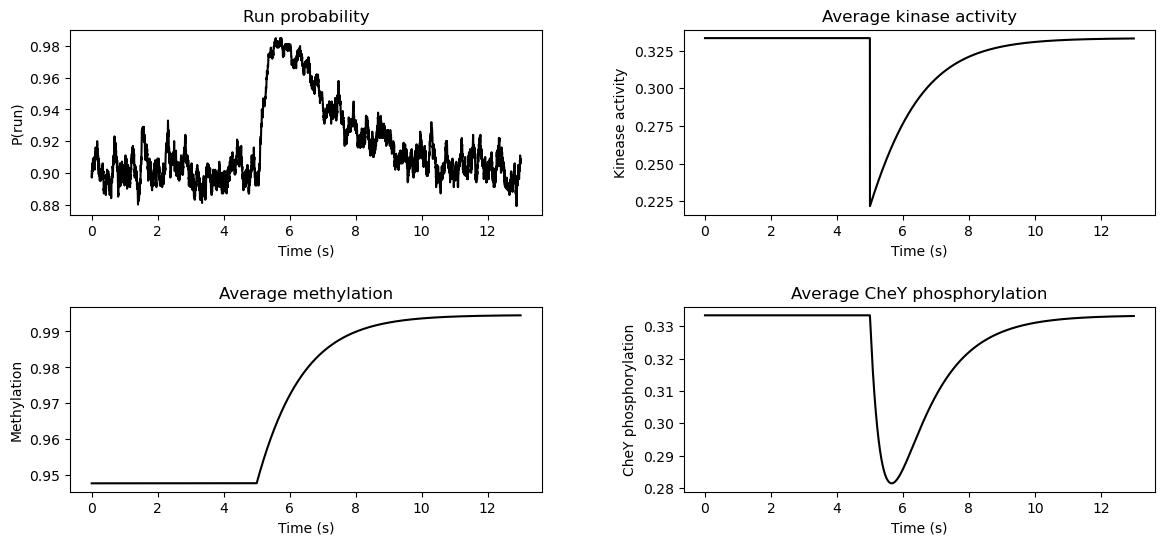

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(14, 6))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

axs[0, 0].plot(Time, prun_pf, c = 'k')
#axs[0, 0].plot(Time[::tau_sub_pf], prun_pf[::tau_sub_pf], c = 'lightgrey', lw = 2, ls = '--')
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_ylabel("P(run)")
axs[0, 0].set_title("Run probability")

axs[0, 1].plot(Time, avg_activity_pf, c = 'k')
#axs[0, 1].plot(Time[::tau_sub_pf], avg_activity[::tau_sub_pf], c = 'lightgrey', lw = 2, ls = '--')
axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_ylabel("Kinease activity")
axs[0, 1].set_title("Average kinase activity")

axs[1, 0].plot(Time, avg_methilatyion_pf, c = 'k')
#axs[1, 0].plot(Time[::tau_sub_pf], avg_methilatyion[::tau_sub_pf], c = 'lightgrey', lw = 2, ls = '--')
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("Methylation")
axs[1, 0].set_title("Average methylation")

axs[1, 1].plot(Time, avg_chey_pf, c = 'k')
#axs[1, 1].plot(Time[::tau_sub_pf], avg_chey[::tau_sub_pf], c = 'lightgrey', lw = 2, ls = '--')
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_ylabel("CheY phosphorylation")
axs[1, 1].set_title("Average CheY phosphorylation")

plt.show()

In [8]:
c_data_pf = [res["concentrations"][::tau_sub] for res in results_model_pf]

c_data_pf = [x/x[-1] for x in c_data_pf]

trajectories_data_pf = []
actions_pf = []
for i, curr_res in enumerate(results_model_pf):

    actions_pf.append(curr_res["actions"].astype(int)[::tau_sub])
    ccurr = c_data_pf[i]

    dict_traj = {}
    dict_traj["actions"] = actions_pf[-1]
    dict_traj["features"] = np.array([np.ones(ccurr.size).astype(np.float32),
                                      ccurr])

    trajectories_data_pf.append(dict_traj)

first_action_pf = np.array([tr["actions"][0] for tr in trajectories_data_pf])

print("Number of trajectories: ", len(trajectories_data_pf))
print("Number of tumbling at the beginning: ", np.sum(first_action_pf))
print("Fraction of tumbling at the beginning: ", np.round(np.sum(first_action_pf) / len(trajectories_data_pf) * 100, 2), "%")

Number of trajectories:  1000
Number of tumbling at the beginning:  99
Fraction of tumbling at the beginning:  9.9 %


In [9]:
F = 2
M = 2
A = 2

In [12]:
cvalues = np.array([0.1, 1])
feature_array = np.array([np.ones(cvalues.size), cvalues])

In [42]:
psi_design = np.array([3, 1])

theta_design = np.array([[[[0.5, 0.5], [0.5, 0.5]],
                          [[0.5, 0.5], [0.5, 0.5]]],
                          [[[0.5, 0.5], [0.5, 0.5]],
                          [[0.5, 0.5], [0.5, 0.5]]]])
theta_design[0, 0, 0, 0] = 2.7
theta_design[0, 0, 1, 0] = -3.5
theta_design[0, 0, 1, 1] = -2
theta_design[0, 1, 0, 1] = -2

theta_design[0, 1, 1, 0] = 2.5
theta_design[0, 1, 0, 0] = 0.005

theta_design[1, 0, 0, 0] = 5
theta_design[1, 0, 1, 0] = 8.3 ###

theta_design[1, 1, 1, 0] = 0.9
theta_design[1, 1, 0, 0] = -2

theta_design[1, 1, 0, 1] = -8


FSC_designed = controller.FSC("continuous", M = M, A = A, F = F, mode = "generation")
FSC_designed.load_parameters(theta_design, psi_design)

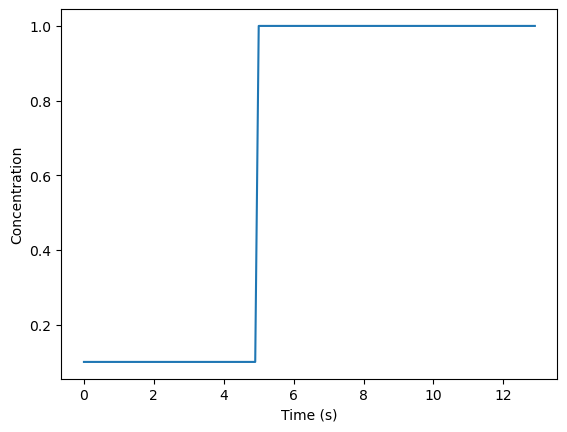

In [43]:
NSteps_play = 200
Ntraj_play = 500
concentration_low = np.ones(NSteps1//tau_sub) * 0.1
concentration_high = np.ones(NSteps2//tau_sub) * 1
concentration = np.concatenate((concentration_low, concentration_high))

features_play = [np.array([np.ones(concentration.size), concentration])]*Ntraj_play

TimePlay = np.arange(0, concentration.size*dt*tau_sub, dt*tau_sub)

plt.plot(TimePlay, concentration)
plt.xlabel("Time (s)")
plt.ylabel("Concentration")
plt.show()

In [44]:
generated_tr = FSC_designed.generate_trajectories(features = features_play)

In [45]:
actions_play = np.array([tr["actions"] for tr in generated_tr])
pr = np.mean(actions_play == 0, axis = 0)

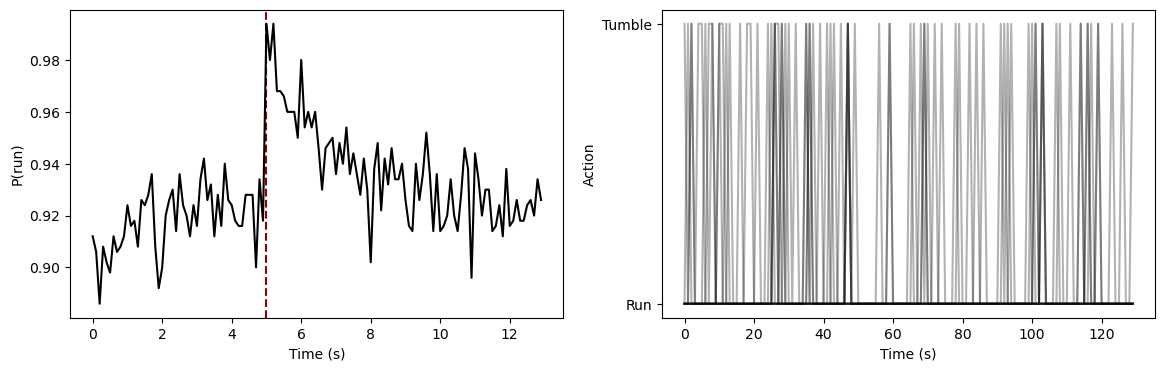

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].axvline(NSteps1*dt, c = 'darkred', ls = '--')
axs[0].plot(TimePlay, pr, c = 'k')
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("P(run)")

axs[1].plot(actions_play[:10].T, c = 'k', alpha = 0.3)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Action")
axs[1].set_yticks([0, 1], labels = ["Run", "Tumble"])

plt.show()

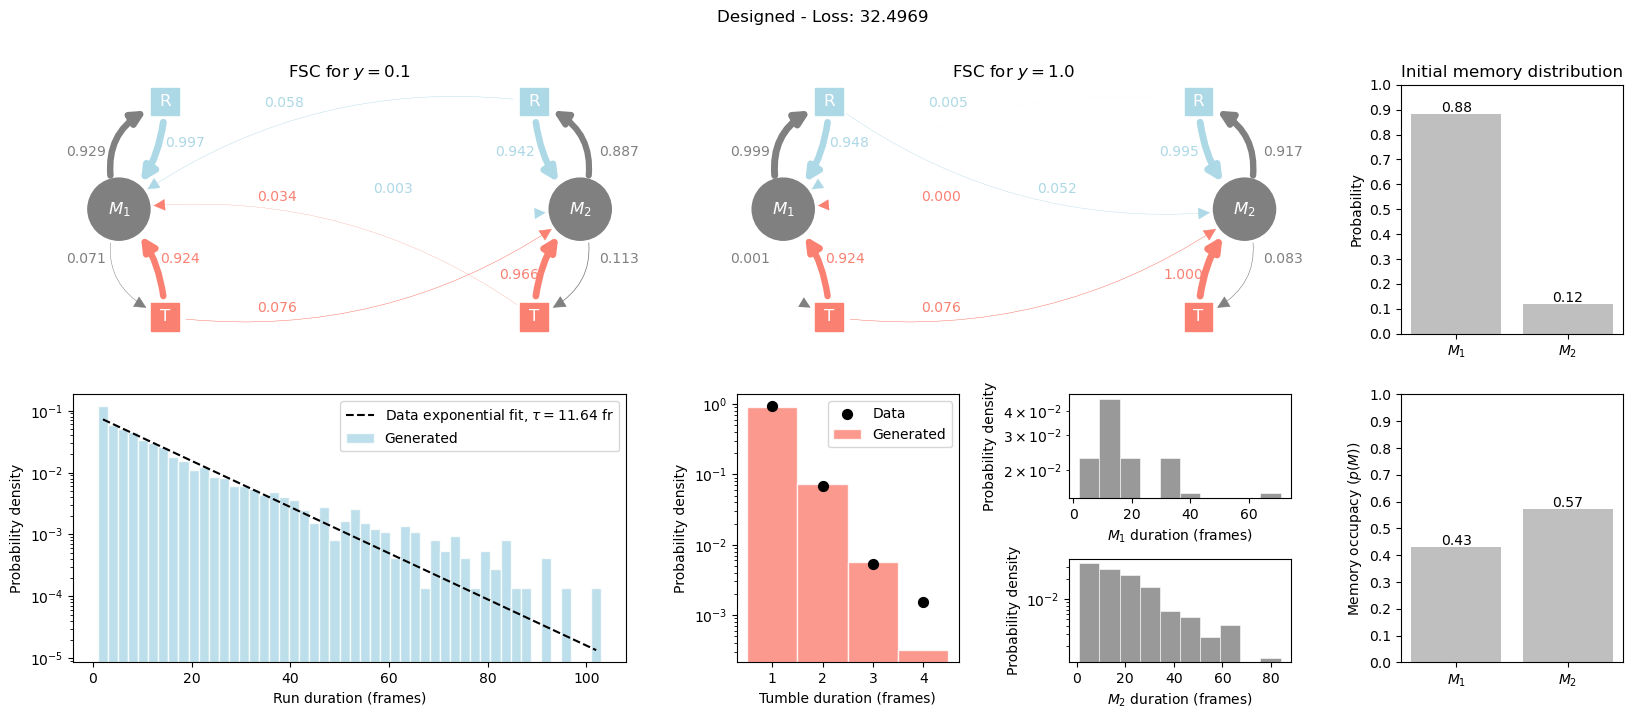

In [47]:
res = FSC_designed.plot_dashboard_M2A2(feature_array, generated_tr, title = f"Designed", return_results = True)

In [ ]:
NEpochs = 20
NBatch = 20
lr = (0.05, 0.05)
gamma = 0.99
train_split = 0.9

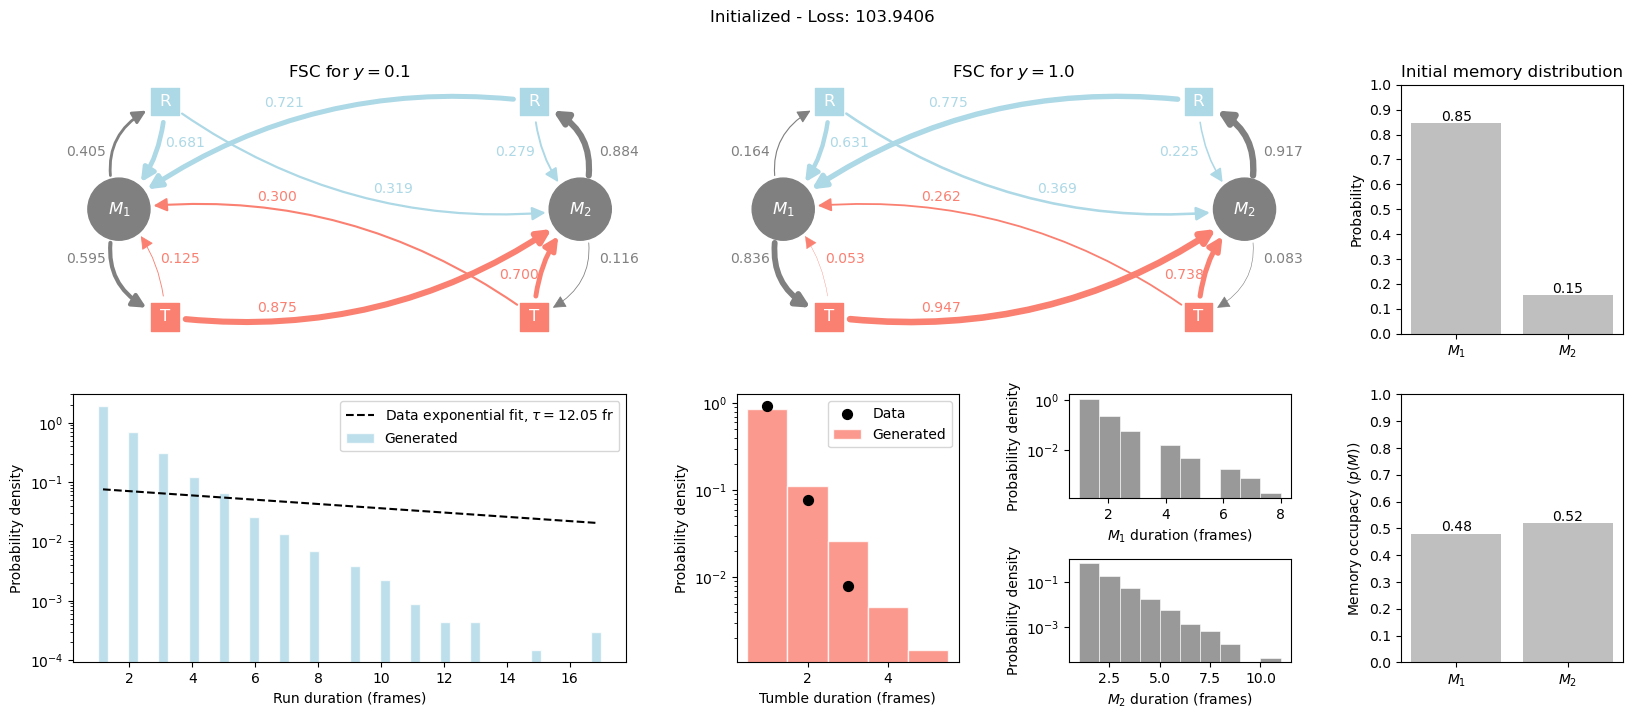

In [23]:
FSC_inferred = controller.FSC("continuous", M = M, A = A, F = F, mode = "generation", seed = 0)
FSC_inferred.plot_dashboard_M2A2(feature_array, generated_tr, title = f"Initialized", return_results = False)

In [25]:
FSC_inferred.set_mode("generation")
tloss, vloss = FSC_inferred.fit(generated_tr,
                                NEpochs = 5,
                                NBatch = 25, lr = (0.05, 0.05),
                                gamma = 0.99, train_split = 0.9)

Training with 450 trajectories and validating with 50 trajectories. Using a single learning rate of 0.05.
Epoch 1 - Training loss: 55.61101250542534, Validation loss: 35.323452949523926 - Learning rate: 0.05
Epoch 2 - Training loss: 33.932263183593754, Validation loss: 36.54595163345337 - Learning rate: 0.0495
Epoch 3 - Training loss: 33.4212542046441, Validation loss: 34.699171180725095 - Learning rate: 0.049005
Epoch 4 - Training loss: 32.75318684895833, Validation loss: 34.45218379974365 - Learning rate: 0.04851495
Epoch 5 - Training loss: 32.61915581597222, Validation loss: 34.40659481048584 - Learning rate: 0.0480298005


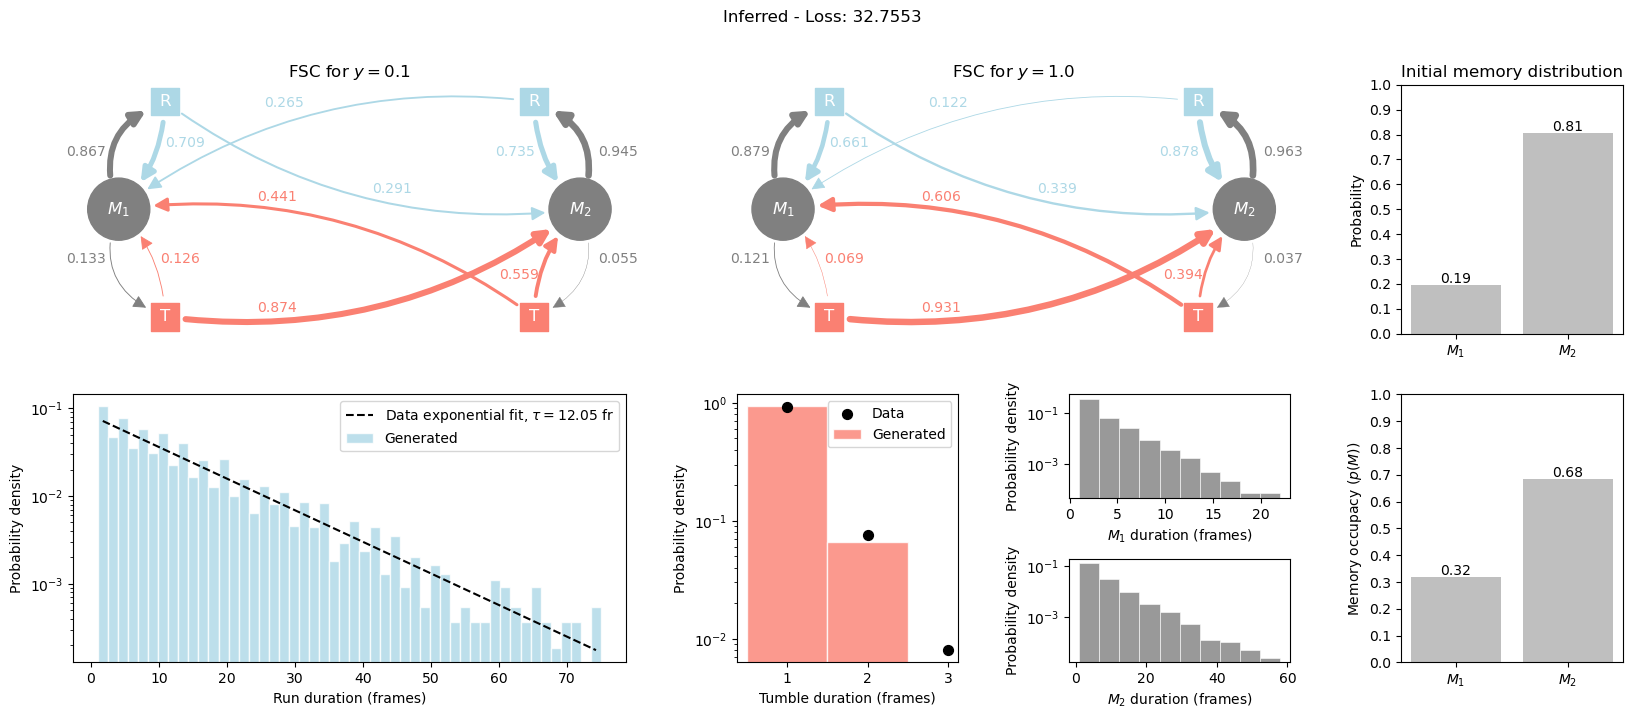

In [26]:
FSC_inferred.set_mode("generation")
res = FSC_inferred.plot_dashboard_M2A2(feature_array, generated_tr, title = f"Inferred", return_results = True)

In [28]:
feature_array_all = np.array([np.ones(100), np.linspace(0, 1.5, 100)])

In [31]:
pr, pm1, pm2,pi1, pi2 = compute_eq_probability(FSC_designed, feature_array_all, verbose = False)
pr_inferred, pm1_inferred, pm2_inferred, pi1_inferred, pi2_inferred = compute_eq_probability(FSC_inferred, feature_array_all, verbose = False)

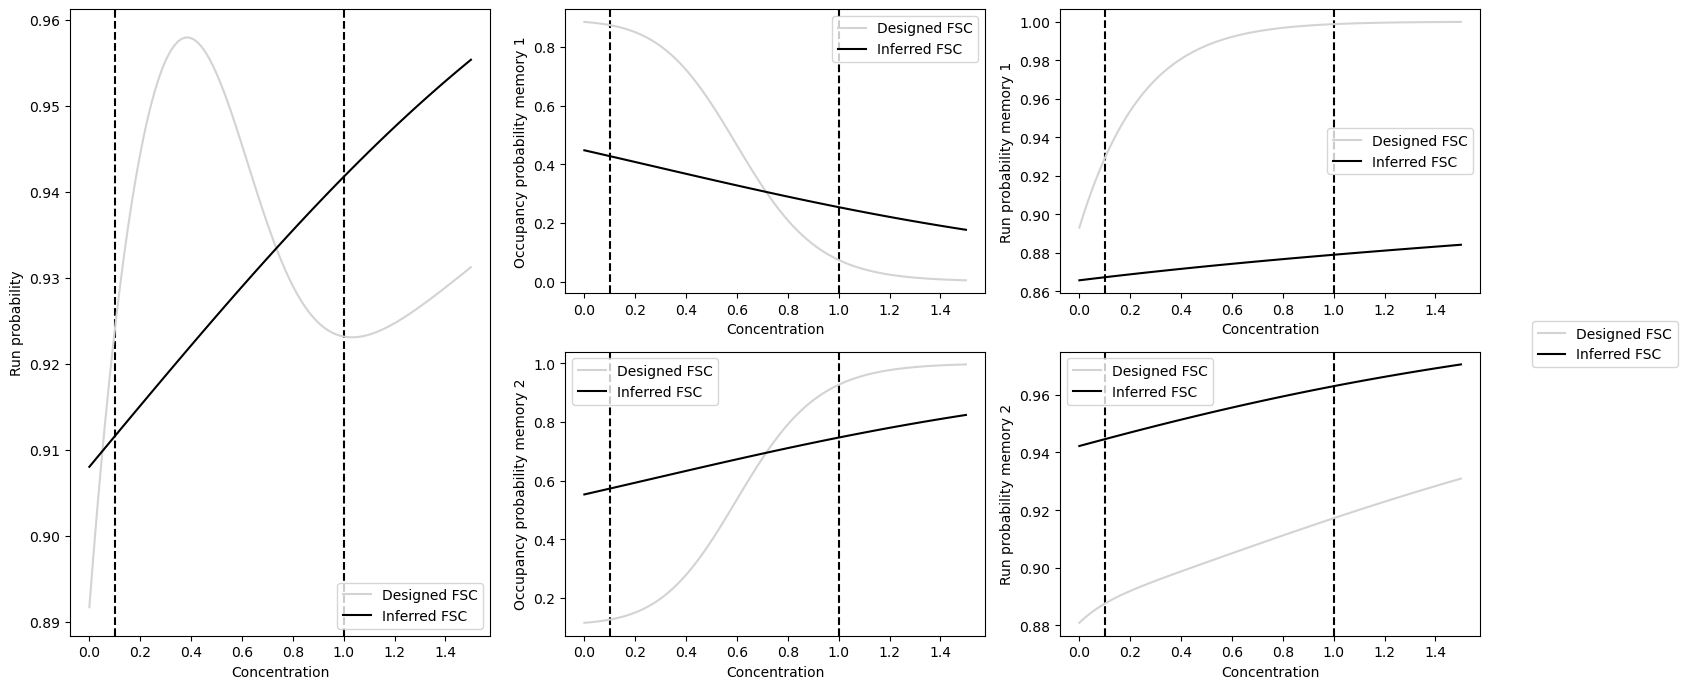

In [35]:
fig, axs = plt.subplot_mosaic([["run_prob", "pm1", "pi1"],
                               ["run_prob", "pm2", "pi2"]], figsize=(15, 7))

# Plot run probability
axs["run_prob"].plot(feature_array_all[1], pr, label="Designed FSC", c='lightgrey', alpha=1)
axs["run_prob"].plot(feature_array_all[1], pr_inferred, label="Inferred FSC", c='black', alpha=1)
axs["run_prob"].set_xlabel("Concentration")
axs["run_prob"].set_ylabel("Run probability")
axs["run_prob"].legend()

# Plot pm1
axs["pm1"].plot(feature_array_all[1], pm1, label="Designed FSC", c='lightgrey', alpha=1)
axs["pm1"].plot(feature_array_all[1], pm1_inferred, label="Inferred FSC", c='black', alpha=1)
axs["pm1"].set_xlabel("Concentration")
axs["pm1"].set_ylabel("Occupancy probability memory 1")
axs["pm1"].legend()

# Plot pm2
axs["pm2"].plot(feature_array_all[1], pm2, label="Designed FSC", c='lightgrey', alpha=1)
axs["pm2"].plot(feature_array_all[1], pm2_inferred, label="Inferred FSC", c='black', alpha=1)
axs["pm2"].set_xlabel("Concentration")
axs["pm2"].set_ylabel("Occupancy probability memory 2")
axs["pm2"].legend()

# Plot pi1
axs["pi1"].plot(feature_array_all[1], pi1, label="Designed FSC", c='lightgrey', alpha=1)
axs["pi1"].plot(feature_array_all[1], pi1_inferred, label="Inferred FSC", c='black', alpha=1)
axs["pi1"].set_xlabel("Concentration")
axs["pi1"].set_ylabel("Run probability memory 1")
axs["pi1"].legend()

# Plot pi2
axs["pi2"].plot(feature_array_all[1], pi2, label="Designed FSC", c='lightgrey', alpha=1)
axs["pi2"].plot(feature_array_all[1], pi2_inferred, label="Inferred FSC", c='black', alpha=1)
axs["pi2"].set_xlabel("Concentration")
axs["pi2"].set_ylabel("Run probability memory 2")
axs["pi2"].legend()

# Add a single legend on the right
handles, labels = axs["run_prob"].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)

for ax in axs.values():
    ax.axvline(0.1, c='k', ls='--', zorder=-1)
    ax.axvline(1, c='k', ls='--', zorder=-1)

plt.tight_layout()
plt.show()

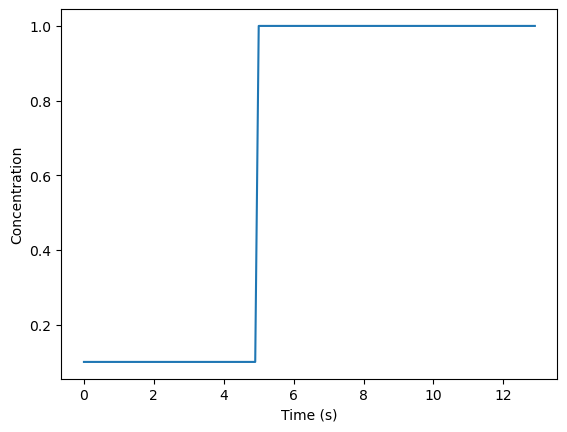

In [36]:
features_play = [np.array([np.ones(len(ccc)), ccc]) for ccc in c_data_pf]*10

TimePlay = np.arange(0, c_data_pf[0].size*dt*tau_sub, dt*tau_sub)

plt.plot(TimePlay, features_play[0][1])
plt.xlabel("Time (s)")
plt.ylabel("Concentration")
plt.show()

In [38]:
generated_tr_inferred= FSC_inferred.generate_trajectories(features = features_play)

In [39]:
actions_play = np.array([tr["actions"] for tr in generated_tr_inferred])
pr = np.mean(actions_play == 0, axis = 0)

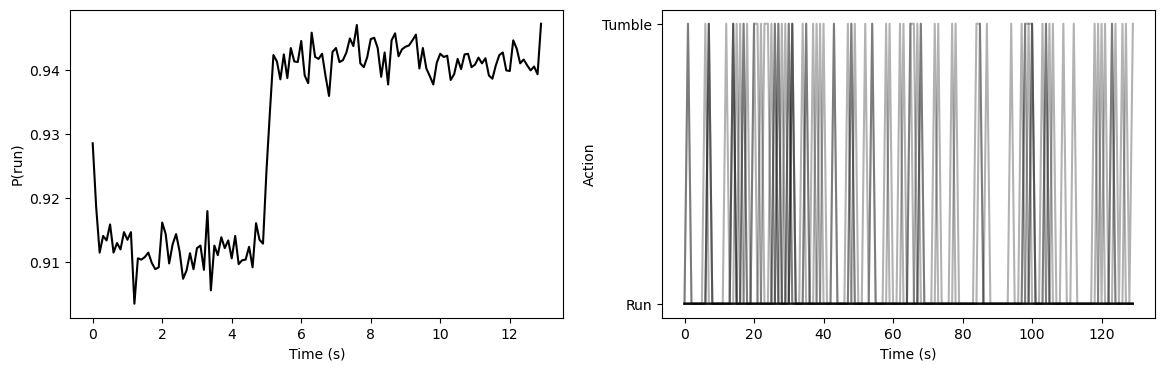

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

#axs[0].axvline(NSteps_play*dt*tau_sub, c = 'darkred', ls = '--')
axs[0].plot(TimePlay, pr, c = 'k')
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("P(run)")

axs[1].plot(actions_play[:10].T, c = 'k', alpha = 0.3)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Action")
axs[1].set_yticks([0, 1], labels = ["Run", "Tumble"])

plt.show()

## Train with more trajectories

In [ ]:
NRep = 1000
NSteps1 = 5000
NSteps2 = 8000
c0 = 0.2
c1 = c0*10
ttumble = 0.1
seeds = np.arange(NRep)
dt = 1e-3

tau_sub = 100

In [ ]:
Time = np.arange(0, (NSteps1 + NSteps2)*dt, dt)

results_model_pf = chem.cswitch_ecoli3D(NRep = NRep, NSteps1 = NSteps1, NSteps2 = NSteps2,
                                        c0 = c0, c1 = c1, ttumble = ttumble, seeds = seeds, dt = dt)

In [ ]:
prun_pf = 1 - np.mean(np.array([res["actions"] for res in results_model_pf]), axis = 0)
avg_activity_pf = np.mean(np.array([res["activity"] for res in results_model_pf]), axis = 0)
avg_methilatyion_pf = np.mean(np.array([res["methylation"] for res in results_model_pf]), axis = 0)
avg_chey_pf = np.mean(np.array([res["chey"] for res in results_model_pf]), axis = 0)

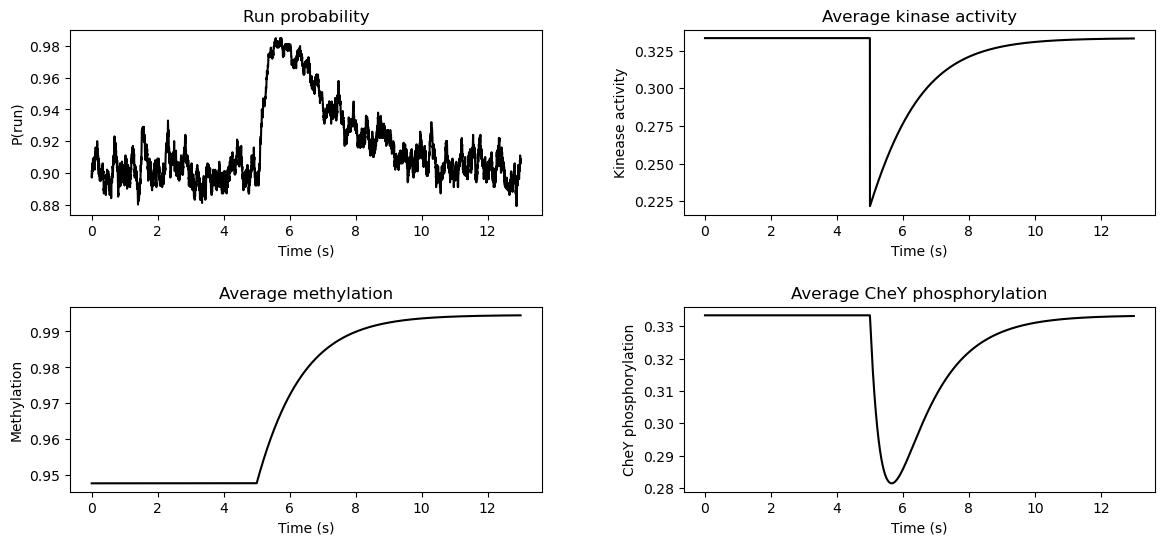

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 6))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

axs[0, 0].plot(Time, prun_pf, c = 'k')
#axs[0, 0].plot(Time[::tau_sub_pf], prun_pf[::tau_sub_pf], c = 'lightgrey', lw = 2, ls = '--')
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_ylabel("P(run)")
axs[0, 0].set_title("Run probability")

axs[0, 1].plot(Time, avg_activity_pf, c = 'k')
#axs[0, 1].plot(Time[::tau_sub_pf], avg_activity[::tau_sub_pf], c = 'lightgrey', lw = 2, ls = '--')
axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_ylabel("Kinease activity")
axs[0, 1].set_title("Average kinase activity")

axs[1, 0].plot(Time, avg_methilatyion_pf, c = 'k')
#axs[1, 0].plot(Time[::tau_sub_pf], avg_methilatyion[::tau_sub_pf], c = 'lightgrey', lw = 2, ls = '--')
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("Methylation")
axs[1, 0].set_title("Average methylation")

axs[1, 1].plot(Time, avg_chey_pf, c = 'k')
#axs[1, 1].plot(Time[::tau_sub_pf], avg_chey[::tau_sub_pf], c = 'lightgrey', lw = 2, ls = '--')
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_ylabel("CheY phosphorylation")
axs[1, 1].set_title("Average CheY phosphorylation")

plt.show()

In [ ]:
c_data_pf = [res["concentrations"][::tau_sub] for res in results_model_pf]

c_data_pf = [x/x[-1] for x in c_data_pf]

trajectories_data_pf = []
actions_pf = []
for i, curr_res in enumerate(results_model_pf):

    actions_pf.append(curr_res["actions"].astype(int)[::tau_sub])
    ccurr = c_data_pf[i]

    dict_traj = {}
    dict_traj["actions"] = actions_pf[-1]
    dict_traj["features"] = np.array([np.ones(ccurr.size).astype(np.float32),
                                      ccurr])

    trajectories_data_pf.append(dict_traj)

first_action_pf = np.array([tr["actions"][0] for tr in trajectories_data_pf])

print("Number of trajectories: ", len(trajectories_data_pf))
print("Number of tumbling at the beginning: ", np.sum(first_action_pf))
print("Fraction of tumbling at the beginning: ", np.round(np.sum(first_action_pf) / len(trajectories_data_pf) * 100, 2), "%")

Number of trajectories:  1000
Number of tumbling at the beginning:  99
Fraction of tumbling at the beginning:  9.9 %


In [ ]:
F = 2
M = 2
A = 2

In [ ]:
cvalues = np.array([0.1, 1])
feature_array = np.array([np.ones(cvalues.size), cvalues])

In [ ]:
psi_design = np.array([3, 1])

theta_design = np.array([[[[0.5, 0.5], [0.5, 0.5]],
                          [[0.5, 0.5], [0.5, 0.5]]],
                          [[[0.5, 0.5], [0.5, 0.5]],
                          [[0.5, 0.5], [0.5, 0.5]]]])
theta_design[0, 0, 0, 0] = 2.7
theta_design[0, 0, 1, 0] = -3.5
theta_design[0, 0, 1, 1] = -2
theta_design[0, 1, 0, 1] = -2

theta_design[0, 1, 1, 0] = 2.5
theta_design[0, 1, 0, 0] = 0.005

theta_design[1, 0, 0, 0] = 5
theta_design[1, 0, 1, 0] = 8.3 ###

theta_design[1, 1, 1, 0] = 0.9
theta_design[1, 1, 0, 0] = -2

theta_design[1, 1, 0, 1] = -8


FSC_designed = controller.FSC("continuous", M = M, A = A, F = F, mode = "generation")
FSC_designed.load_parameters(theta_design, psi_design)

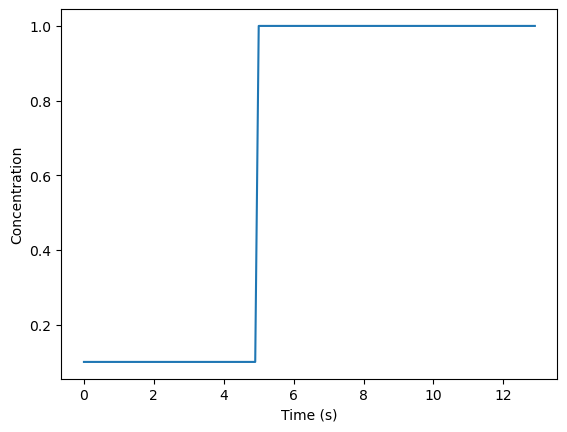

In [ ]:
NSteps_play = 200
Ntraj_play = 500
concentration_low = np.ones(NSteps1//tau_sub) * 0.1
concentration_high = np.ones(NSteps2//tau_sub) * 1
concentration = np.concatenate((concentration_low, concentration_high))

features_play = [np.array([np.ones(concentration.size), concentration])]*Ntraj_play

TimePlay = np.arange(0, concentration.size*dt*tau_sub, dt*tau_sub)

plt.plot(TimePlay, concentration)
plt.xlabel("Time (s)")
plt.ylabel("Concentration")
plt.show()

In [ ]:
generated_tr = FSC_designed.generate_trajectories(features = features_play)

In [ ]:
actions_play = np.array([tr["actions"] for tr in generated_tr])
pr = np.mean(actions_play == 0, axis = 0)

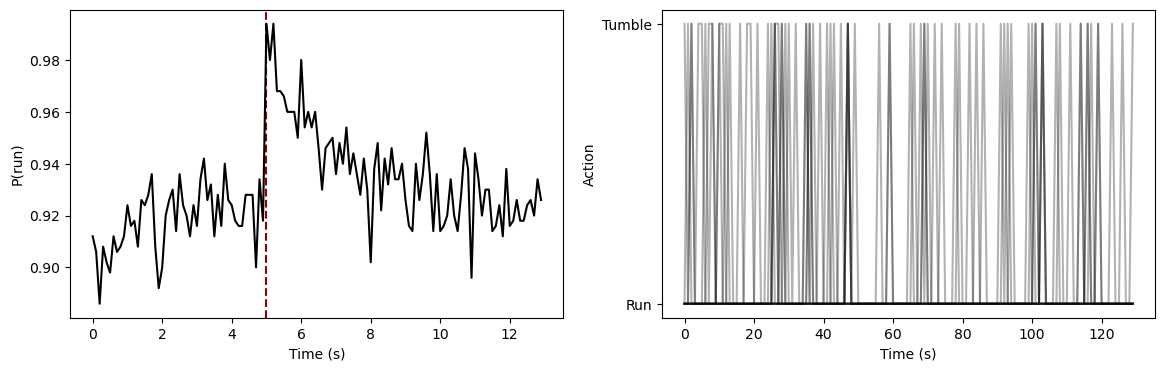

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].axvline(NSteps1*dt, c = 'darkred', ls = '--')
axs[0].plot(TimePlay, pr, c = 'k')
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("P(run)")

axs[1].plot(actions_play[:10].T, c = 'k', alpha = 0.3)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Action")
axs[1].set_yticks([0, 1], labels = ["Run", "Tumble"])

plt.show()

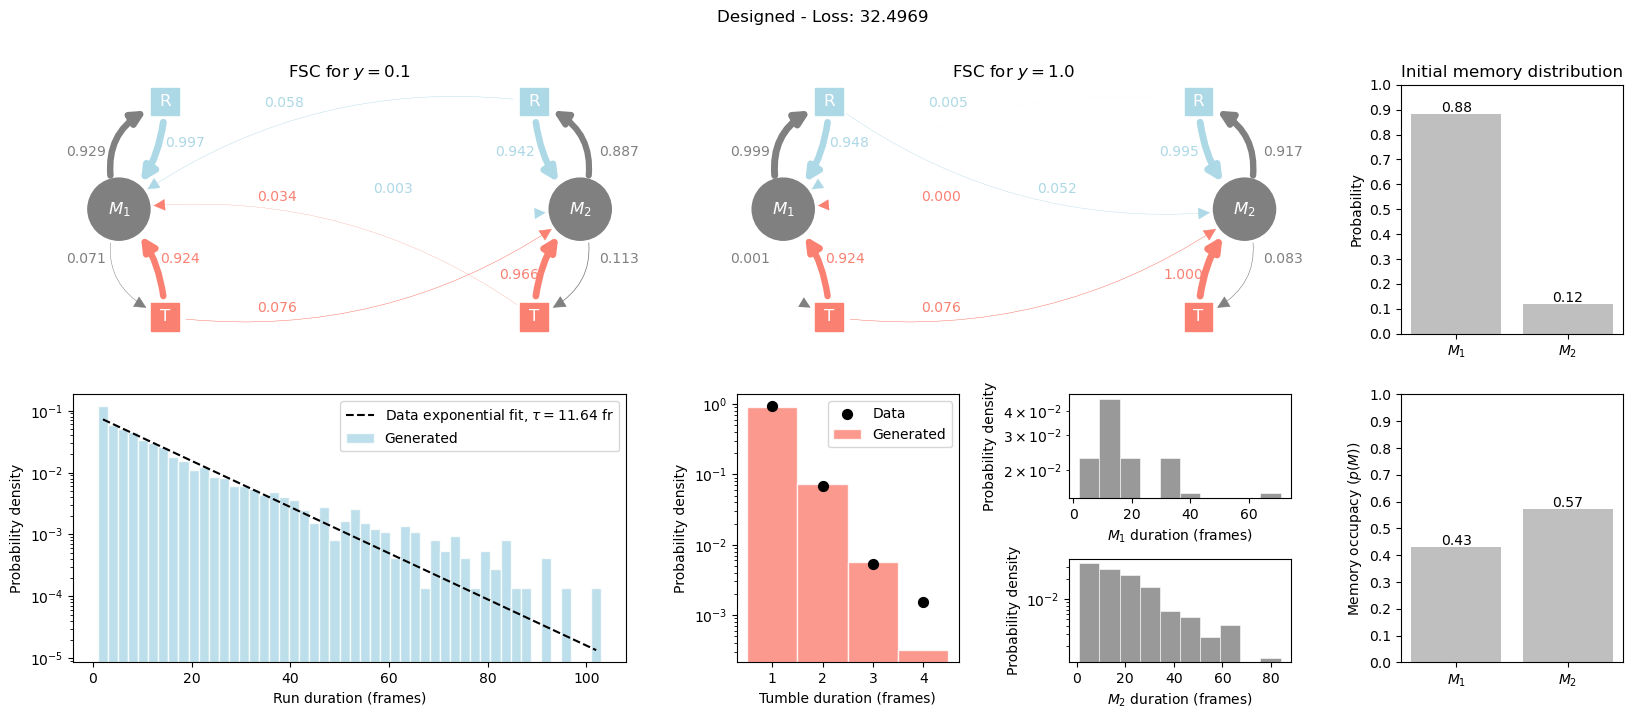

In [ ]:
res = FSC_designed.plot_dashboard_M2A2(feature_array, generated_tr, title = f"Designed", return_results = True)

In [ ]:
NEpochs = 20
NBatch = 20
lr = (0.05, 0.05)
gamma = 0.99
train_split = 0.9

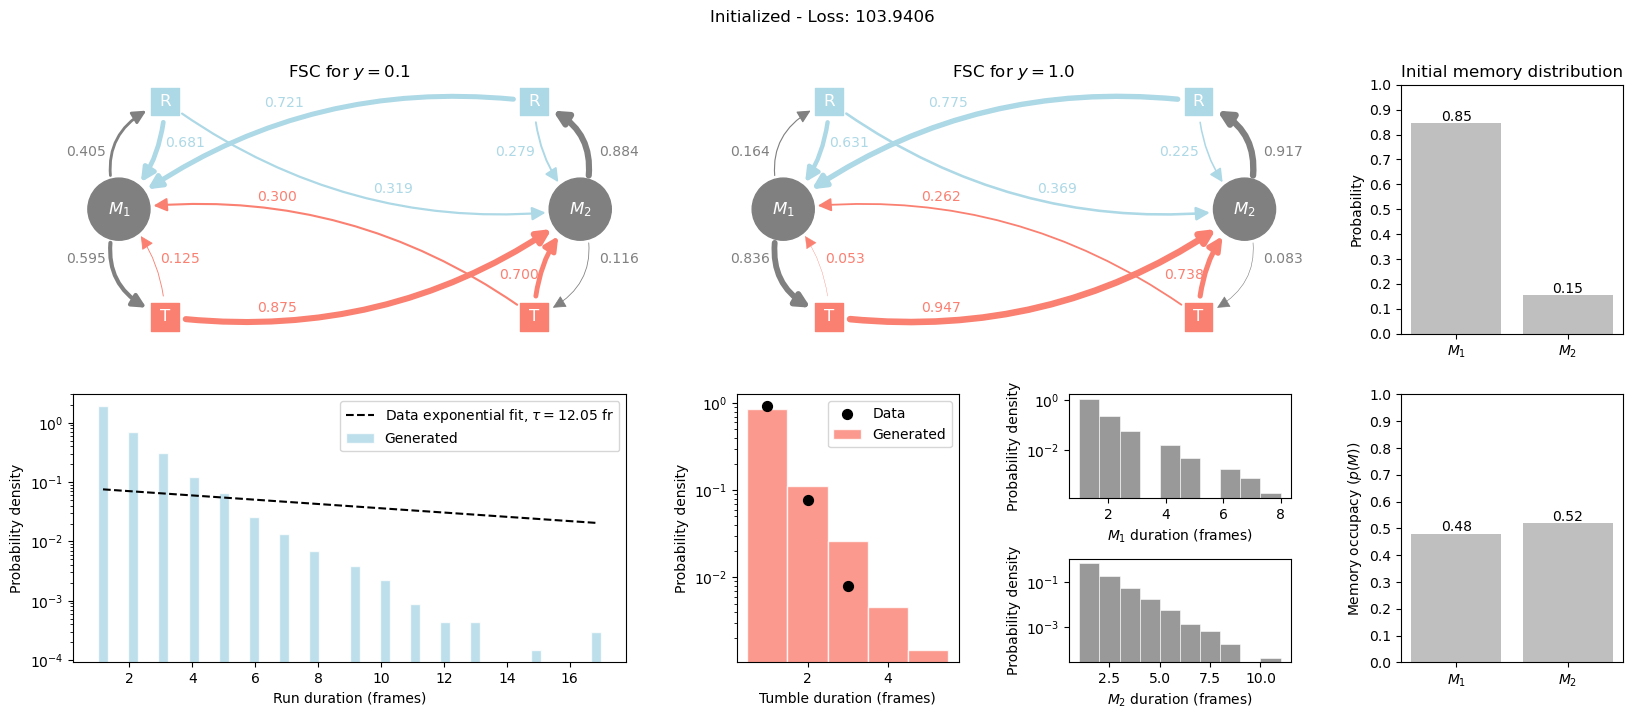

In [ ]:
FSC_inferred = controller.FSC("continuous", M = M, A = A, F = F, mode = "generation", seed = 0)
FSC_inferred.plot_dashboard_M2A2(feature_array, generated_tr, title = f"Initialized", return_results = False)

In [ ]:
FSC_inferred.set_mode("generation")
tloss, vloss = FSC_inferred.fit(generated_tr,
                                NEpochs = 5,
                                NBatch = 25, lr = (0.05, 0.05),
                                gamma = 0.99, train_split = 0.9)

Training with 450 trajectories and validating with 50 trajectories. Using a single learning rate of 0.05.
Epoch 1 - Training loss: 55.61101250542534, Validation loss: 35.323452949523926 - Learning rate: 0.05
Epoch 2 - Training loss: 33.932263183593754, Validation loss: 36.54595163345337 - Learning rate: 0.0495
Epoch 3 - Training loss: 33.4212542046441, Validation loss: 34.699171180725095 - Learning rate: 0.049005
Epoch 4 - Training loss: 32.75318684895833, Validation loss: 34.45218379974365 - Learning rate: 0.04851495
Epoch 5 - Training loss: 32.61915581597222, Validation loss: 34.40659481048584 - Learning rate: 0.0480298005


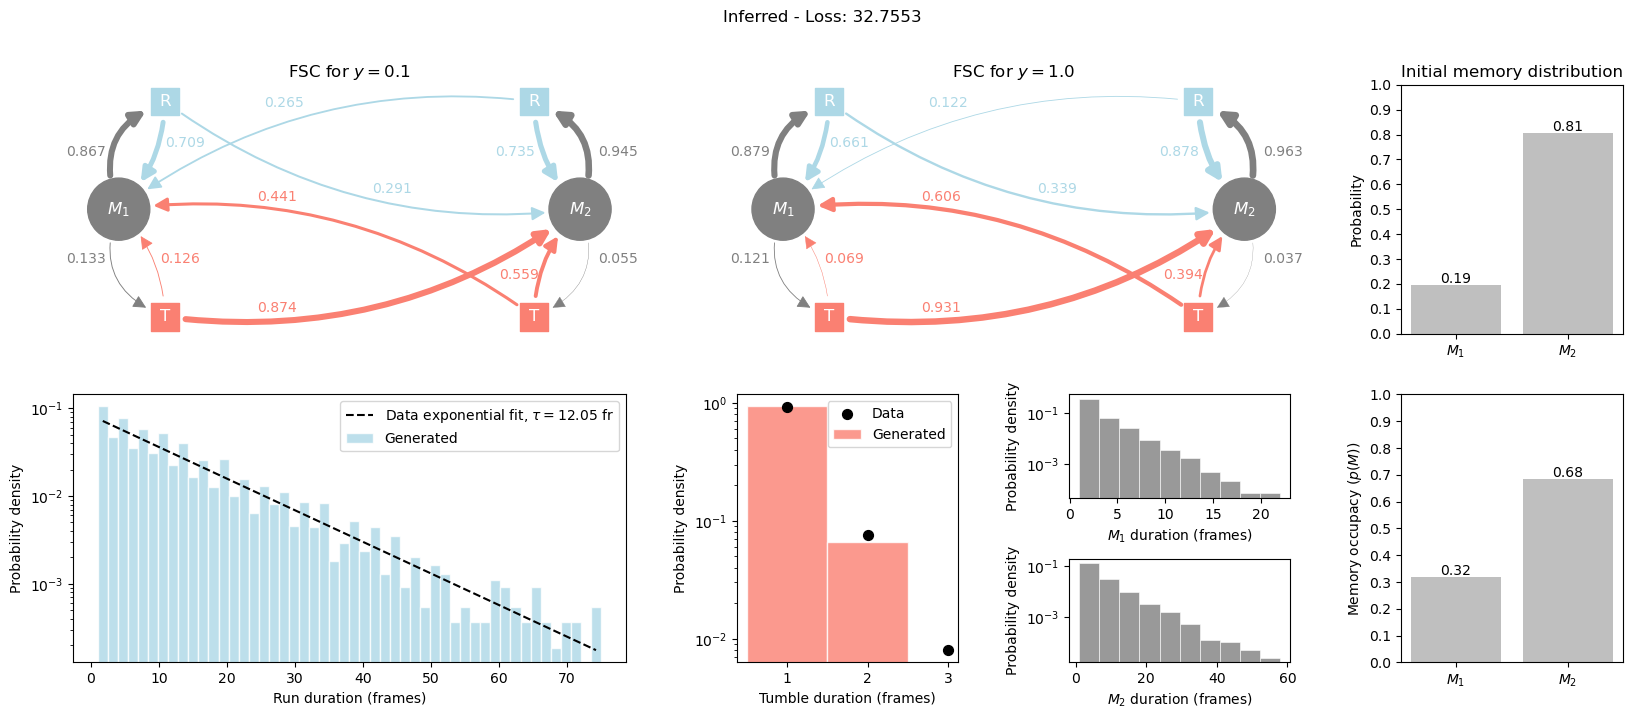

In [ ]:
FSC_inferred.set_mode("generation")
res = FSC_inferred.plot_dashboard_M2A2(feature_array, generated_tr, title = f"Inferred", return_results = True)

In [ ]:
feature_array_all = np.array([np.ones(100), np.linspace(0, 1.5, 100)])

In [ ]:
pr, pm1, pm2,pi1, pi2 = compute_eq_probability(FSC_designed, feature_array_all, verbose = False)
pr_inferred, pm1_inferred, pm2_inferred, pi1_inferred, pi2_inferred = compute_eq_probability(FSC_inferred, feature_array_all, verbose = False)

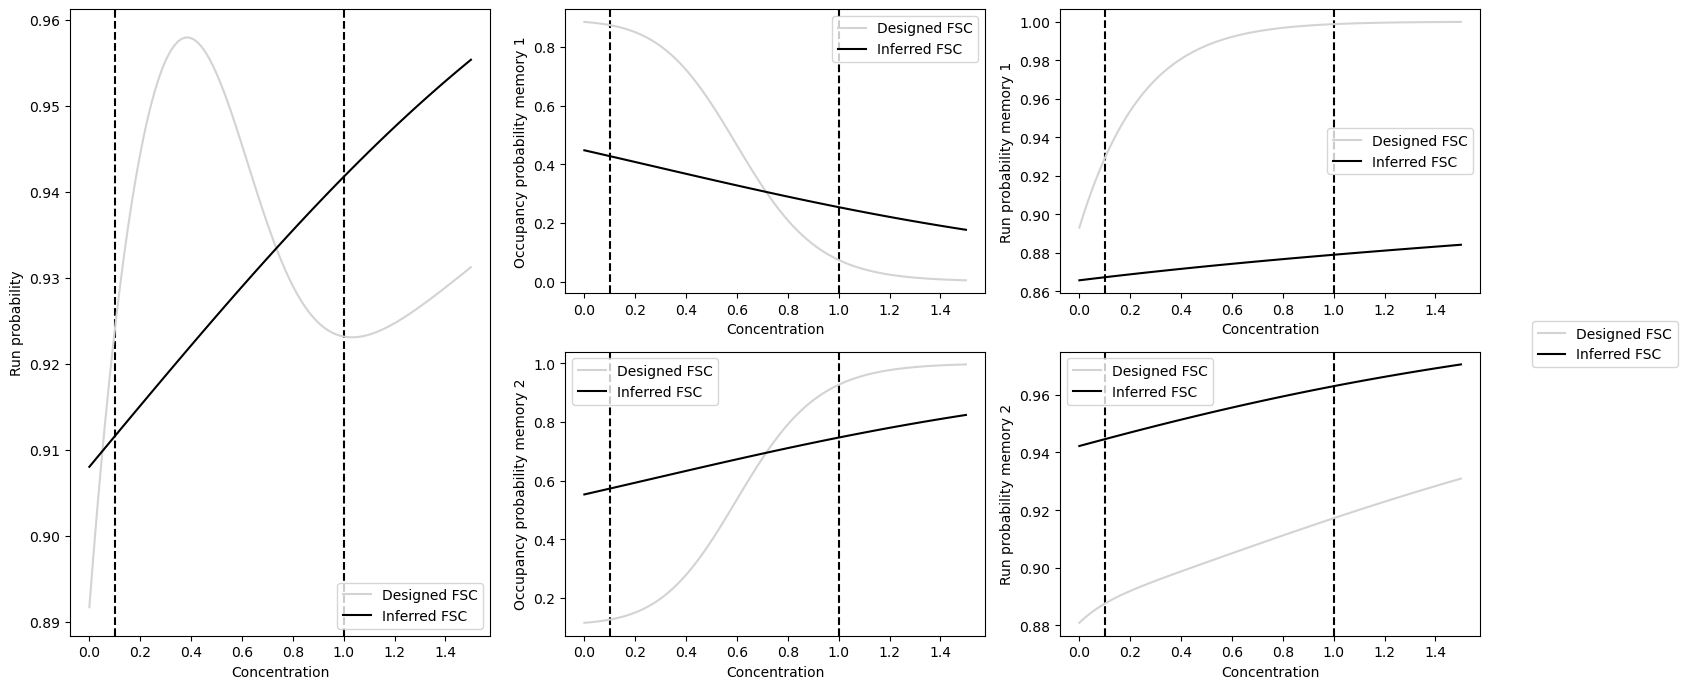

In [ ]:
fig, axs = plt.subplot_mosaic([["run_prob", "pm1", "pi1"],
                               ["run_prob", "pm2", "pi2"]], figsize=(15, 7))

# Plot run probability
axs["run_prob"].plot(feature_array_all[1], pr, label="Designed FSC", c='lightgrey', alpha=1)
axs["run_prob"].plot(feature_array_all[1], pr_inferred, label="Inferred FSC", c='black', alpha=1)
axs["run_prob"].set_xlabel("Concentration")
axs["run_prob"].set_ylabel("Run probability")
axs["run_prob"].legend()

# Plot pm1
axs["pm1"].plot(feature_array_all[1], pm1, label="Designed FSC", c='lightgrey', alpha=1)
axs["pm1"].plot(feature_array_all[1], pm1_inferred, label="Inferred FSC", c='black', alpha=1)
axs["pm1"].set_xlabel("Concentration")
axs["pm1"].set_ylabel("Occupancy probability memory 1")
axs["pm1"].legend()

# Plot pm2
axs["pm2"].plot(feature_array_all[1], pm2, label="Designed FSC", c='lightgrey', alpha=1)
axs["pm2"].plot(feature_array_all[1], pm2_inferred, label="Inferred FSC", c='black', alpha=1)
axs["pm2"].set_xlabel("Concentration")
axs["pm2"].set_ylabel("Occupancy probability memory 2")
axs["pm2"].legend()

# Plot pi1
axs["pi1"].plot(feature_array_all[1], pi1, label="Designed FSC", c='lightgrey', alpha=1)
axs["pi1"].plot(feature_array_all[1], pi1_inferred, label="Inferred FSC", c='black', alpha=1)
axs["pi1"].set_xlabel("Concentration")
axs["pi1"].set_ylabel("Run probability memory 1")
axs["pi1"].legend()

# Plot pi2
axs["pi2"].plot(feature_array_all[1], pi2, label="Designed FSC", c='lightgrey', alpha=1)
axs["pi2"].plot(feature_array_all[1], pi2_inferred, label="Inferred FSC", c='black', alpha=1)
axs["pi2"].set_xlabel("Concentration")
axs["pi2"].set_ylabel("Run probability memory 2")
axs["pi2"].legend()

# Add a single legend on the right
handles, labels = axs["run_prob"].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)

for ax in axs.values():
    ax.axvline(0.1, c='k', ls='--', zorder=-1)
    ax.axvline(1, c='k', ls='--', zorder=-1)

plt.tight_layout()
plt.show()

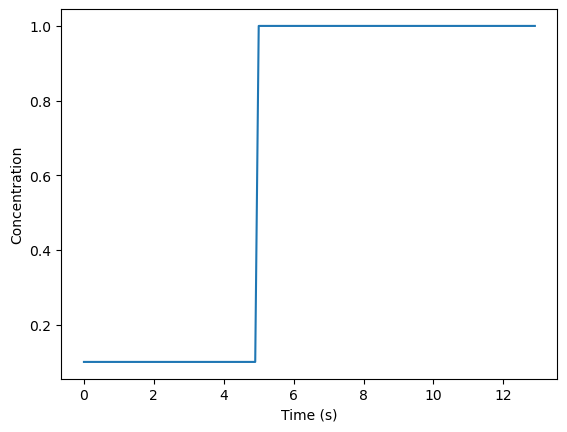

In [ ]:
features_play = [np.array([np.ones(len(ccc)), ccc]) for ccc in c_data_pf]*10

TimePlay = np.arange(0, c_data_pf[0].size*dt*tau_sub, dt*tau_sub)

plt.plot(TimePlay, features_play[0][1])
plt.xlabel("Time (s)")
plt.ylabel("Concentration")
plt.show()

In [ ]:
generated_tr_inferred= FSC_inferred.generate_trajectories(features = features_play)

In [ ]:
actions_play = np.array([tr["actions"] for tr in generated_tr_inferred])
pr = np.mean(actions_play == 0, axis = 0)

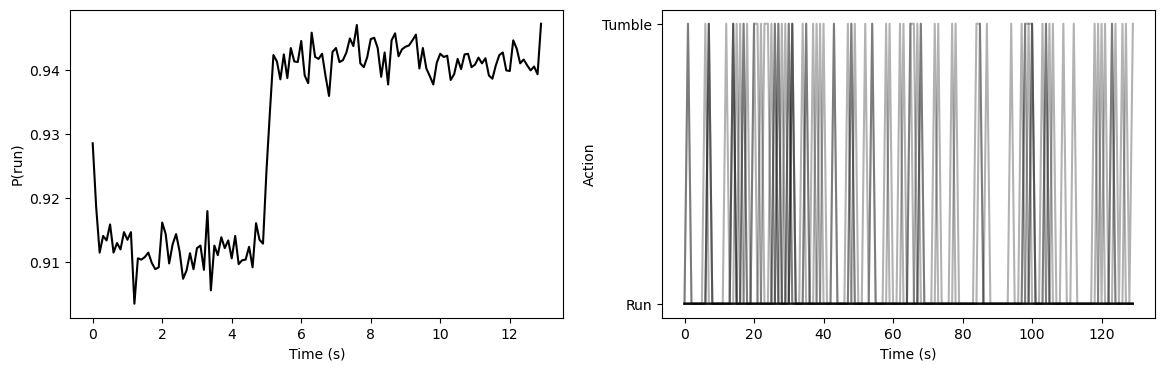

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

#axs[0].axvline(NSteps_play*dt*tau_sub, c = 'darkred', ls = '--')
axs[0].plot(TimePlay, pr, c = 'k')
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("P(run)")

axs[1].plot(actions_play[:10].T, c = 'k', alpha = 0.3)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Action")
axs[1].set_yticks([0, 1], labels = ["Run", "Tumble"])

plt.show()